# Лабораторная работа №2
Шубина София Антоновна НПИбд-02-23 


**План анализа данных о прокате велосипедов:**

1. **Загрузка и первичная проверка данных**
   - Импорт данных из файла `bikes_rent.csv`
   - Проверка наличия пропущенных значений
   - Проверка наличия дублирующихся записей

2. **Подготовка данных для моделирования**
   - Формирование матрицы признаков (X) и вектора целевой переменной (y)
   - Разделение данных на обучающую и тестовую выборки
   - Преобразование категориальных переменных в числовой формат

3. **Анализ взаимосвязей признаков**
   - Построение матрицы корреляций между признаками
   - Выявление сильно коррелирующих признаков

4. **Построение прогнозных моделей**
   - **Модель A:** Линейная регрессия с использованием всех признаков
   - **Модель B:** Линейная регрессия после удаления сильно коррелирующих признаков
   - **Модель C:** Линейная регрессия с регуляризацией (Ridge/Lasso) на всех признаках

5. **Сравнительная оценка моделей**
   - Расчет метрик RMSE и R² для всех трех моделей
   - Сравнительный анализ качества прогнозирования
   - Выводы об эффективности разных подходов

**Оцениваемые метрики:**
- RMSE (Root Mean Square Error) - среднеквадратичная ошибка
- R² (коэффициент детерминации) - доля объясненной дисперсии

**Цель:** Определить наиболее эффективный метод обработки коррелирующих признаков для прогнозирования количества прокатов велосипедов.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('bikes_rent.csv')
# Проверка на наличие пропусков
data.info()
data.head()
print("Пропущенные значения:")
print(data.isnull().sum())
print(f"\nВсего пропусков: {data.isnull().sum().sum()}")
print(f"\nДубликаты: {data.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          731 non-null    object 
 1   mnth            731 non-null    int64  
 2   holiday         731 non-null    int64  
 3   weekday         731 non-null    object 
 4   weathersit      731 non-null    object 
 5   temp            731 non-null    float64
 6   atemp           731 non-null    float64
 7   hum             731 non-null    float64
 8   windspeed(mph)  731 non-null    float64
 9   windspeed(ms)   731 non-null    float64
 10  cnt             731 non-null    int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 62.9+ KB
Пропущенные значения:
season            0
mnth              0
holiday           0
weekday           0
weathersit        0
temp              0
atemp             0
hum               0
windspeed(mph)    0
windspeed(ms)     0
cnt               0
dtype

Матрица признаков включает все характеристики кроме столбца с количеством арендованных велосипедов и представляет собой входные данные которые модель будет анализировать для построения прогнозов. Вектор целевой переменной содержит исключительно значения столбца с количеством прокатов и является тем показателем который необходимо предсказать на основе имеющихся признаков. Вывод размерностей демонстрирует структуру полученных данных показывая количество наблюдений и переменных в каждой из созданных частей.

In [4]:
# 2. Формирование матрицы признаков и вектора целевой переменной
X = data.drop('cnt', axis=1)
y = data['cnt']

print(f"\nРазмерность признаков: {X.shape}")
print(f"Размерность целевой переменной: {y.shape}")


Размерность признаков: (731, 10)
Размерность целевой переменной: (731,)


Функция train_test_split случайным образом распределяет исходные данные на две части где большая часть отводится для обучения модели а меньшая для проверки ее эффективности. Параметр test_size определяет долю данных которые будут использоваться для тестирования в данном случае двадцать процентов. Параметр random_state обеспечивает воспроизводимость результатов фиксируя случайное распределение данных. Обучающая выборка используется для построения модели а тестовая для объективной оценки ее качества на ранее не встречавшихся данных что позволяет проверить способность модели к обобщению. Вывод размерностей показывает сколько наблюдений содержится в каждой из созданных выборок.

In [5]:
# 3. Формирование обучающей и тестовой выборок
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nОбучающая выборка: {X_train.shape}, {y_train.shape}")
print(f"Тестовая выборка: {X_test.shape}, {y_test.shape}")



Обучающая выборка: (584, 10), (584,)
Тестовая выборка: (147, 10), (147,)


Создаются копии обучающих и тестовых данных чтобы сохранить исходные значения. Для каждого категориального признака применяется кодирование где каждому текстовому значению присваивается уникальное число. На обучающих данных метод fit_transform одновременно изучает возможные категории и преобразует их а на тестовых данных transform применяет уже learned соответствия без переобучения чтобы обеспечить согласованность кодирования. Вывод показывает какие текстовые значения в какие числа были преобразованы для каждого признака.



In [8]:
# 4. Замена категориальных данных на числовые
# Создаем копии данных для разных подходов
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# Список категориальных признаков
categorical_columns = ['season', 'weekday', 'weathersit']

# Применяем Label Encoding для категориальных признаков
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col])
    X_test_encoded[col] = le.transform(X_test_encoded[col])
    label_encoders[col] = le

print("\nКатегориальные признаки после кодирования:")
for col in categorical_columns:
    print(f"{col}: {label_encoders[col].classes_}")


Категориальные признаки после кодирования:
season: ['autumn' 'spring' 'summer' 'winter']
weekday: ['fr' 'mon' 'sat' 'sun' 'thu' 'tue' 'wed']
weathersit: ['cloudy' 'rain' 'sunny']


Строится матрица корреляций которая показывает степень линейной зависимости между всеми числовыми признаками. Тепловая карта визуализирует эту матрицу с помощью цветовой шкалы где значения близкие к единице указывают на сильную положительную связь близкие к минус единице на сильную отрицательную связь а near нулю на отсутствие линейной зависимости. Аннотации с числовыми значениями позволяют точно оценить силу корреляций. Это помогает выявить дублирующие или сильно связанные признаки которые могут ухудшить качество модели.

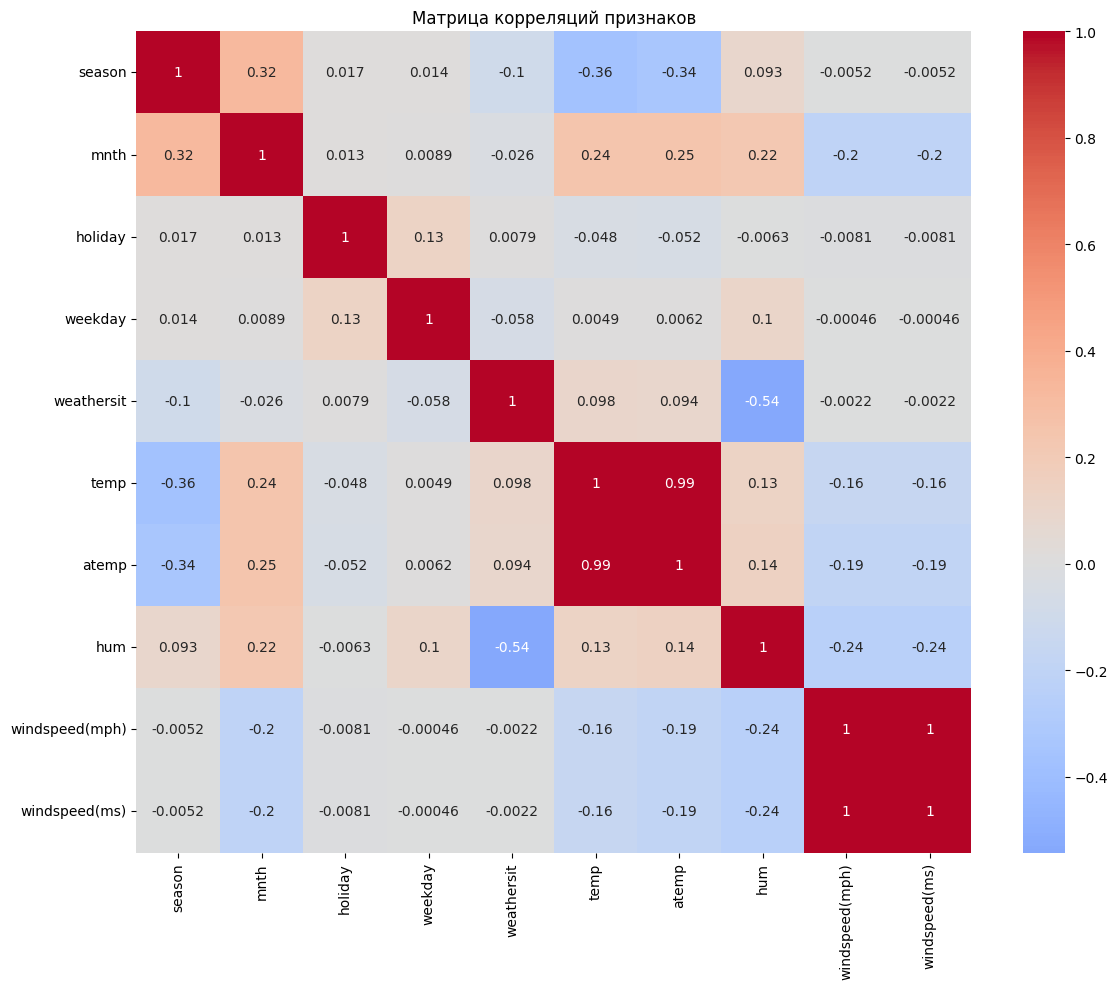

In [9]:
# 5. Проверка данных на корреляцию
plt.figure(figsize=(12, 10))
correlation_matrix = X_train_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций признаков')
plt.tight_layout()
plt.show()

 Алгоритм попарно проверяет все комбинации признаков и вычисляет коэффициенты корреляции между ними. Если абсолютное значение корреляции превышает порог 0.8 такие признаки считаются сильно связанными. Все обнаруженные высококоррелированные признаки добавляются в множество для последующего анализа. Результаты выводятся в виде пар признаков с указанием точного значения корреляции между ними а затем формируется общий список всех признаков имеющих сильные взаимосвязи. Это помогает идентифицировать дублирующую информацию в данных которую желательно устранить перед построением моделей.

In [10]:
# Находим сильно коррелирующие признаки (коэффициент корреляции > 0.8)
high_corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_corr_features.add(colname_i)
            high_corr_features.add(colname_j)
            print(f"Высокая корреляция между {colname_i} и {colname_j}: {correlation_matrix.iloc[i, j]:.3f}")

print(f"\nСильно коррелирующие признаки: {high_corr_features}")

Высокая корреляция между atemp и temp: 0.990
Высокая корреляция между windspeed(ms) и windspeed(mph): 1.000

Сильно коррелирующие признаки: {'windspeed(mph)', 'windspeed(ms)', 'temp', 'atemp'}


В первом случае модель обучается на всех признаках без учета корреляций между ними. Во втором подходе из данных предварительно удаляются сильно коррелирующие признаки чтобы исключить дублирующую информацию и мультиколлинеарность. Для каждой модели вычисляются метрики качества RMSE и R² которые показывают точность прогнозирования и объясненную дисперсию соответственно. Сравнение этих метрик позволяет оценить эффективность удаления коррелирующих признаков для улучшения работы модели.

In [ ]:
# 6. Обучение моделей линейной регрессии

# Случай 1: без учета корреляции данных
print("СЛУЧАЙ 1: Без учета корреляции данных")

lr_model1 = LinearRegression()
lr_model1.fit(X_train_encoded, y_train)
y_pred1 = lr_model1.predict(X_test_encoded)

rmse1 = np.sqrt(mean_squared_error(y_test, y_pred1))
r2_1 = r2_score(y_test, y_pred1)

print(f"RMSE: {rmse1:.2f}")
print(f"R2: {r2_1:.4f}")

# Случай 2: с учетом корреляции данных (удаляем сильно коррелирующие признаки)
print("СЛУЧАЙ 2: С учетом корреляции данных")

# Удаляем сильно коррелирующие признаки
# Оставляем temp вместо atemp, windspeed(mph) вместо windspeed(ms)
columns_to_drop = ['atemp', 'windspeed(ms)']
X_train_no_corr = X_train_encoded.drop(columns=columns_to_drop)
X_test_no_corr = X_test_encoded.drop(columns=columns_to_drop)

print(f"Признаки после удаления коррелирующих: {X_train_no_corr.columns.tolist()}")

lr_model2 = LinearRegression()
lr_model2.fit(X_train_no_corr, y_train)
y_pred2 = lr_model2.predict(X_test_no_corr)

rmse2 = np.sqrt(mean_squared_error(y_test, y_pred2))
r2_2 = r2_score(y_test, y_pred2)

print(f"RMSE: {rmse2:.2f}")
print(f"R2: {r2_2:.4f}")


СЛУЧАЙ 1: Без учета корреляции данных
RMSE: 1392.27
R2: 0.5166

СЛУЧАЙ 2: С учетом корреляции данных
Признаки после удаления коррелирующих: ['season', 'mnth', 'holiday', 'weekday', 'weathersit', 'temp', 'hum', 'windspeed(mph)']
RMSE: 1392.00
R2: 0.5168


Реализуем Ridge-регрессию с регуляризацией для борьбы с мультиколлинеарностью без удаления признаков. Затем выполняется комплексное сравнение трех моделей: обычной линейной регрессии регрессии с удаленными коррелирующими признаками и Ridge-регрессии. Результаты сравниваются через метрики RMSE и R² с визуализацией в виде столбчатых диаграмм и графиков рассеяния предсказанных значений против фактических. В заключение определяется лучшая модель на основе максимального значения R² и выводятся итоговые показатели ее эффективности для финальной оценки.


СЛУЧАЙ 3: Ridge регрессия
RMSE: 1391.65
R2: 0.5170

СРАВНЕНИЕ РЕЗУЛЬТАТОВ
                                      Модель         RMSE        R2  \
0  Линейная регрессия (без учета корреляции)  1392.274656  0.516587   
1   Линейная регрессия (с учетом корреляции)  1391.999295  0.516778   
2                            Ridge регрессия  1391.645649  0.517024   

   Количество признаков  
0                    10  
1                     8  
2                    10  


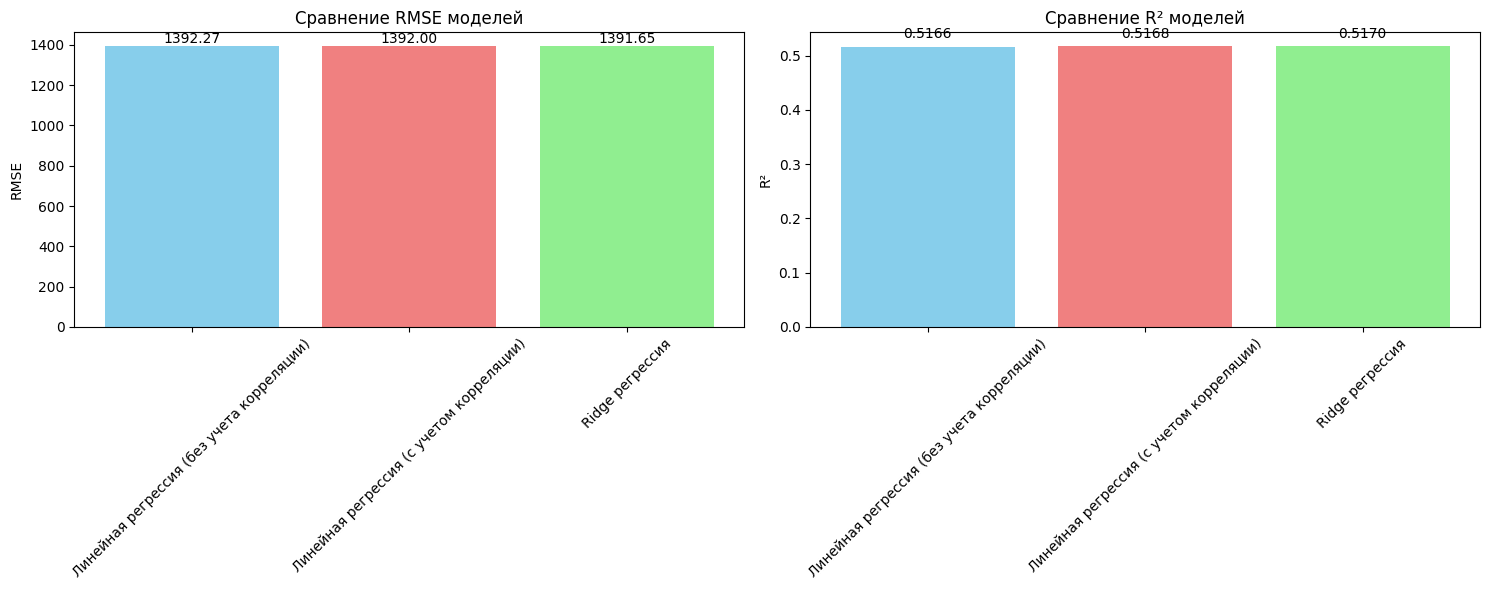

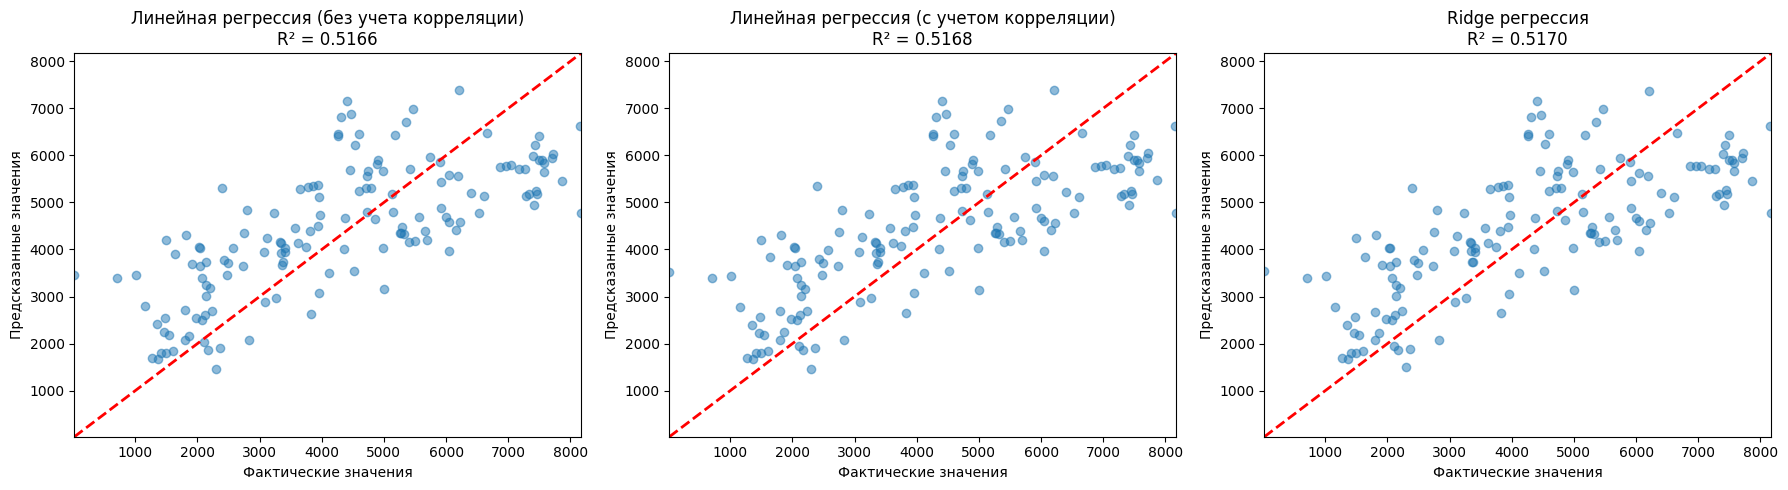


ФИНАЛЬНЫЕ ВЫВОДЫ
Лучшая модель: Ridge регрессия
Лучший R²: 0.5170
Лучший RMSE: 1391.65


In [ ]:
# 7. Обучение модели линейной регрессии с регуляризацией (Ridge)
print("Ridge регрессия")

ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_encoded, y_train)
y_pred_ridge = ridge_model.predict(X_test_encoded)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"RMSE: {rmse_ridge:.2f}")
print(f"R2: {r2_ridge:.4f}")

# 8. Сравнение результатов
print("\n" + "="*60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*60)

results = pd.DataFrame({
    'Модель': ['Линейная регрессия (без учета корреляции)', 
               'Линейная регрессия (с учетом корреляции)',
               'Ridge регрессия'],
    'RMSE': [rmse1, rmse2, rmse_ridge],
    'R2': [r2_1, r2_2, r2_ridge],
    'Количество признаков': [X_train_encoded.shape[1], 
                           X_train_no_corr.shape[1],
                           X_train_encoded.shape[1]]
})

print(results)

# Визуализация сравнения моделей
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График RMSE
models = results['Модель']
rmse_values = results['RMSE']
bars = ax1.bar(models, rmse_values, color=['skyblue', 'lightcoral', 'lightgreen'])
ax1.set_title('Сравнение RMSE моделей')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)
for bar, value in zip(bars, rmse_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.2f}', ha='center', va='bottom')

# График R2
r2_values = results['R2']
bars = ax2.bar(models, r2_values, color=['skyblue', 'lightcoral', 'lightgreen'])
ax2.set_title('Сравнение R² моделей')
ax2.set_ylabel('R²')
ax2.tick_params(axis='x', rotation=45)
for bar, value in zip(bars, r2_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Визуализация прогнозов vs фактические значения
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.ravel()

predictions = [y_pred1, y_pred2, y_pred_ridge]
titles = ['Линейная регрессия (без учета корреляции)', 
          'Линейная регрессия (с учетом корреляции)',
          'Ridge регрессия']

for i, (ax, y_pred, title) in enumerate(zip(axes, predictions, titles)):
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel('Фактические значения')
    ax.set_ylabel('Предсказанные значения')
    ax.set_title(f'{title}\nR² = {results.iloc[i]["R2"]:.4f}')
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.tight_layout()
plt.show()

# Финальные выводы
print("ФИНАЛЬНЫЕ ВЫВОДЫ")
best_model_idx = results['R2'].idxmax()
best_model_name = results.loc[best_model_idx, 'Модель']
best_r2 = results.loc[best_model_idx, 'R2']
best_rmse = results.loc[best_model_idx, 'RMSE']

print(f"Лучшая модель: {best_model_name}")
print(f"Лучший R²: {best_r2:.4f}")
print(f"Лучший RMSE: {best_rmse:.2f}")



# ВЫВОД 

Проведенное исследование позволило сравнить различные подходы к построению моделей линейной регрессии для прогнозирования спроса на прокат велосипедов. На основе полученных результатов можно сделать следующие ключевые выводы:

1. **Качество моделей** всех трех подходов оказалось практически идентичным, с незначительными различиями в метриках. Все модели объясняют около 51.7% дисперсии данных (R² ≈ 0.517), что свидетельствует об умеренной предсказательной способности.

2. **Методы борьбы с мультиколлинеарностью** показали схожую эффективность:
   - Ridge-регрессия продемонстрировала наилучший результат (R² = 0.5170)
   - Удаление коррелирующих признаков дало незначительное улучшение по сравнению с базовой моделью
   - Оба метода являются практически равноценными для данной задачи

3. **Выявленные сильные корреляции** между признаками (temp/atemp - 0.990, windspeed в разных единицах - 1.000) подтвердили необходимость обработки мультиколлинеарности, однако ее влияние на конечное качество прогноза оказалось минимальным.

4. **Наиболее эффективным подходом** признана Ridge-регрессия, которая позволяет сохранить все признаки при одновременном снижении влияния мультиколлинеарности за счет регуляризации.

Таким образом, для прогнозирования спроса на велосипеды можно рекомендовать использование Ridge-регрессии как метода, обеспечивающего стабильное качество прогноза при сохранении всей доступной информации о признаках.